In [1]:
import numpy as np
import cv2
import skimage.io as skio
import json
import scipy.interpolate as ssi
import matplotlib.pyplot as plt
import imageio
import skimage as ski

import skimage.transform
import scipy.signal as ssg

In [2]:
def stack_ones(pts):
    return np.concatenate([pts, np.ones((pts.shape[0], 1))], axis=1)

def stack_zeros(pts):
    return np.concatenate([pts, np.zeros((pts.shape[0], 1))], axis=1)

In [3]:
def warpImage(im, H, h_min, w_min, h_max, w_max):
    new_h = h_max - h_min
    new_w = w_max - w_min

    y_dest, x_dest = np.indices([new_h, new_w])
    dest = np.vstack([x_dest.ravel() + w_min, y_dest.ravel() + h_min, np.ones(x_dest.size)])
    backward_pts_homog = (np.linalg.inv(H) @ dest) # backward points in homogenous coordinates
    backward_pts = (backward_pts_homog[:2]/backward_pts_homog[2]).T # Convert
    
    backward_pts = np.flip(backward_pts, axis=1)
    interp = ssi.RegularGridInterpolator((np.arange(im.shape[0]), np.arange(im.shape[1])), im, bounds_error=False, fill_value=0) # An interpolator
    
    warped_pts = interp(backward_pts)
    warped_im = np.zeros([new_h, new_w, im.shape[-1]])
    warped_im[y_dest.ravel(), x_dest.ravel()] = warped_pts
    return warped_im

In [4]:
def computeH(x, y):
    b = y.flatten()
    
    A = []
    for row in range(len(x)*2):
        A.append([0]*8)

        offset = 0
        if row % 2 == 1:
            offset = 3
        A[-1][offset] = x[row // 2][0]
        A[-1][offset + 1] = x[row // 2][1]
        A[-1][offset + 2] = 1

        A[-1][-2] = -x[row//2][0]*b[row]
        A[-1][-1] = -x[row//2][1]*b[row]

    A = np.array(A)
    H = np.concatenate([np.linalg.lstsq(A, b)[0], [1]]).reshape(3, 3)
    return H

In [5]:
def getWarpedImBounds(im, H):
    h, w = im.shape[:2]
    corners = np.array([[0, 0, 1], [w - 1, 0, 1], [0, h - 1, 1], [w - 1, h - 1, 1]])

    warped_corners_homog = H @ corners.T
    warped_corners = warped_corners_homog[:2]/warped_corners_homog[2:]

    w_min, h_min = np.floor(np.min(warped_corners, axis=1)).astype(int)
    w_max, h_max = np.ceil(np.max(warped_corners, axis=1)).astype(int)
    return h_min, w_min, h_max, w_max

In [6]:
def visualize_points(pts, im):
    plt.plot(pts[:, 0], pts[:, 1], 'o')
    plt.gca().set_aspect("equal")
    plt.imshow(im)
#     plt.axis("off")
    plt.show()

In [7]:
format_type = "berkeley"
left = skio.imread(f"imgs/{format_type}_left.jpg")
center = skio.imread(f"imgs/{format_type}_center.jpg")
right = skio.imread(f"imgs/{format_type}_right.jpg")

In [8]:
corrs = {} # Correspondences

In [9]:
with open(f"correspondences/{format_type}_left_{format_type}_center.json") as fb:
    corrs["leftcenter"] = json.load(fb)
    
with open(f"correspondences/{format_type}_center_{format_type}_right.json") as fb:
    corrs["centerright"] = json.load(fb)

In [10]:
left_pts = np.array(corrs["leftcenter"]["im1Points"])
centerleft_pts = np.array(corrs["leftcenter"]["im2Points"])

centerright_pts = np.array(corrs["centerright"]["im1Points"])
right_pts = np.array(corrs["centerright"]["im2Points"])

In [11]:
scale = 1/8 # .5
left = ski.transform.rescale(left, scale, channel_axis=2)
center = ski.transform.rescale(center, scale, channel_axis=2)
right = ski.transform.rescale(right, scale, channel_axis=2)
left_pts = left_pts*scale
centerleft_pts = centerleft_pts*scale
centerright_pts = centerright_pts*scale
right_pts = right_pts*scale

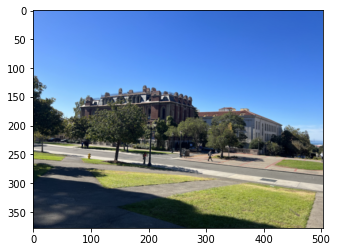

In [12]:
plt.imshow(left)

In [13]:
topgrad = np.tile(np.linspace(0, 1, left.shape[0]//2)[:, np.newaxis], left.shape[1])
bottomgrad = np.tile(np.linspace(1, 0, left.shape[0]//2)[:, np.newaxis], left.shape[1])
leftgrad = np.tile(np.linspace(0, 1, left.shape[1]//2)[:, np.newaxis], left.shape[0])
rightgrad = np.tile(np.linspace(1, 0, left.shape[1]//2)[:, np.newaxis], left.shape[0])

vertgrad = np.concatenate([topgrad, bottomgrad])
horzgrad = np.concatenate([leftgrad, rightgrad]).T
grad = horzgrad*vertgrad

In [14]:
left = np.concatenate([left, grad[..., np.newaxis]], axis=-1)
right = np.concatenate([right, grad[..., np.newaxis]], axis=-1)
center = np.concatenate([center, 2*grad[..., np.newaxis]], axis=-1)

In [15]:
H_left = computeH(left_pts, centerleft_pts)
H_right = computeH(right_pts, centerright_pts)

<ipython-input-4-5afc2942f5f0>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H = np.concatenate([np.linalg.lstsq(A, b)[0], [1]]).reshape(3, 3)


In [16]:
centerleft_pts

array([[198.25 , 159.25 ],
       [182.75 , 147.25 ],
       [278.5  , 193.5  ],
       [ 29.   , 128.75 ],
       [200.625, 216.   ],
       [214.375, 243.25 ],
       [132.   , 271.875],
       [ 57.625, 188.25 ],
       [222.5  , 200.375]])

In [17]:
left.shape

(378, 504, 4)

In [18]:
testwarp = warpImage(left, H_left, -200, -600, center.shape[0] + 200,  200 + center.shape[1])

In [19]:
H_left

array([[ 2.49174346e+00,  7.05231563e-02, -5.55003546e+02],
       [ 4.62098307e-01,  2.07658223e+00, -2.18160638e+02],
       [ 2.80912389e-03,  2.73801744e-04,  1.00000000e+00]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


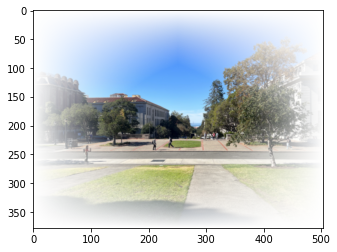

In [41]:
plt.imshow(center)

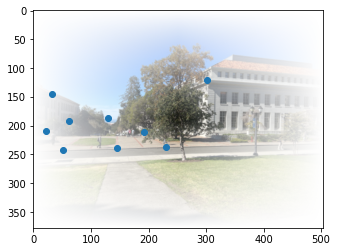

In [21]:
visualize_points(right_pts, right)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


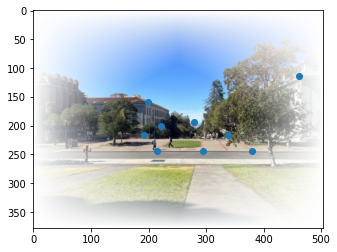

In [22]:
visualize_points(centerright_pts, center)

In [23]:
dst = center
lh_min, lw_min, lh_max, lw_max = getWarpedImBounds(left, H_left)
rh_min, rw_min, rh_max, rw_max = getWarpedImBounds(right, H_right)

h_min = min(lh_min, rh_min, 0)
w_min = min(lw_min, rw_min, 0)
h_max = max(lh_max - lh_min, rh_max, dst.shape[0])
w_max = max(lw_max - lw_min, rw_max, dst.shape[1])

In [24]:
# Shape the destination image to be in the right location
dst = np.pad(dst, np.abs([[h_min, h_max - dst.shape[0]], [w_min, w_max - dst.shape[1]], [0, 0]]))

In [39]:
leftwarped = warpImage(left, H_left, h_min, w_min, h_max, w_max)
rightwarped = warpImage(right, H_right, h_min, w_min, h_max, w_max)

In [26]:
blended = (leftwarped[..., :3] * leftwarped[..., 3:] + rightwarped[..., :3] * rightwarped[..., 3:] + dst[..., :3] * dst[..., 3:]) # *full_mask
opacity = leftwarped[..., 3:] + rightwarped[..., 3:] + dst[..., 3:]
opacity[opacity == 0] = 1
blended = blended/opacity

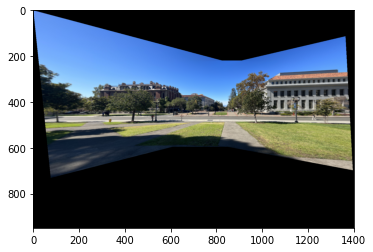

In [27]:
plt.imshow(blended)

In [28]:
ski.io.imsave(f"{format_type}_panorama.jpg", (blended*255).astype(np.uint8))

In [29]:
# Get a rectified version

In [ ]:
corrs.keys()

In [ ]:
rectify_im = skio.imread(f"imgs/hallway.jpg")
with open(f"correspondences/hallway_hallway.json") as fb:
    corrs["rectify"] = json.load(fb)
rectifyPoints = np.array(corrs["rectify"]["im1Points"])

In [ ]:
scale = 1
rectify_im = ski.transform.rescale(rectify_im, scale, channel_axis=2)
rectifyPoints = rectifyPoints*scale

In [ ]:
rectify_im.shape

In [ ]:
plt.imshow(rectify_im)

In [ ]:
visualize_points(rectifyPoints, rectify_im)

In [ ]:
rectify_im.shape

In [ ]:
H_rectify = computeH(rectifyPoints, np.array([[0, 0], [100, -100], [100, 100], [200, 0]]))

In [ ]:
rh_min, rw_min, rh_max, rw_max = getWarpedImBounds(rectify_im, H_rectify)

In [ ]:
rh_max

In [ ]:
rh_min

In [ ]:
rectify_warped = warpImage(rectify_im, H_rectify, rh_min - 1000, rw_min - 500, rh_max + 500, rw_max + 500)

In [ ]:
plt.imshow(rectify_warped)

In [ ]:
ski.io.imsave("rectified_hallway.jpg", (rectify_warped*255).astype(np.uint8))

In [ ]:
# Do the Dubrovnik ones

In [ ]:
left = skio.imread(f"imgs/dubrovnik_left.jpg")
right = skio.imread(f"imgs/dubrovnik_right.jpg")

In [ ]:
corrs = {} # Correspondences

In [ ]:
with open(f"correspondences/dubrovnik_left_dubrovnik_right.json") as fb:
    dubrovnik_pts = json.load(fb)

In [ ]:
left_pts = np.array(dubrovnik_pts["im1Points"])
right_pts = np.array(dubrovnik_pts["im2Points"])

In [ ]:
scale = .5
left = ski.transform.rescale(left, scale, channel_axis=2)
right = ski.transform.rescale(right, scale, channel_axis=2)
left_pts = left_pts*scale
right_pts = right_pts*scale

In [ ]:
plt.imshow(left)

In [ ]:
plt.imshow(right)

In [ ]:
topgrad = np.tile(np.linspace(0, 1, left.shape[0]//2)[:, np.newaxis], left.shape[1])
bottomgrad = np.tile(np.linspace(1, 0, left.shape[0]//2)[:, np.newaxis], left.shape[1])
leftgrad = np.tile(np.linspace(0, 1, left.shape[1]//2)[:, np.newaxis], left.shape[0])
rightgrad = np.tile(np.linspace(1, 0, left.shape[1]//2)[:, np.newaxis], left.shape[0])

vertgrad = np.concatenate([topgrad, bottomgrad])
horzgrad = np.concatenate([leftgrad, rightgrad]).T
grad = horzgrad*vertgrad

In [ ]:
left = np.concatenate([left, grad[..., np.newaxis]], axis=-1)
right = np.concatenate([right, grad[..., np.newaxis]], axis=-1)

In [ ]:
H_left = computeH(left_pts, right_pts)

In [ ]:
dst = right
h_min, w_min, h_max, w_max = getWarpedImBounds(left, H_left)

h_min = min(h_min, 0)
w_min = min(w_min, 0)
h_max = max(h_max, dst.shape[0])
w_max = max(w_max, dst.shape[1])

In [ ]:
h_min

In [ ]:
# Shape the destination image to be in the right location
dst = np.pad(dst, np.abs([[h_min, h_max - dst.shape[0]], [w_min, w_max - dst.shape[1]], [0, 0]]))

In [ ]:
leftwarped = warpImage(left, H_left, h_min, w_min, h_max, w_max)

In [ ]:
blended = (leftwarped[..., :3] * leftwarped[..., 3:] + dst[..., :3] * dst[..., 3:]) # *full_mask
opacity = leftwarped[..., 3:] + dst[..., 3:]
opacity[opacity == 0] = 1
blended = blended/opacity

In [ ]:
plt.imshow(blended)

In [ ]:
ski.io.imsave("dubrovnik_panorama.jpg", (blended*255).astype(np.uint8))